# Addestramento e Valutazione di Faster R-CNN per il Rilevamento di Segnali Stradali

Questo notebook implementa una pipeline per l'addestramento e la valutazione del modello **Faster R-CNN**.

---

## Impostazione dell'Ambiente:

* Installazione delle dipendenze necessarie.

* Importazione delle librerie richieste.

In [1]:
!pip install torch
!pip install torchvision

In [2]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -U .
!pip wheel .
%cd ..

fatal: destination path 'detectron2' already exists and is not an empty directory.
/kaggle/working/detectron2
Processing /kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6445021 sha256=fa6d354373c1dc1450f2435209758c681ee4598cbc89b92c7573de41089fe424
  Stored in directory: /tmp/pip-ephem-wheel-cache-9hmi3ldv/wheels/9f/fe/db/9fd277c4ab6355f9a970c98126917b584e2c982dfc05294c70
Successfully built detectron2
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
Processing /kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
  File was already downloaded /kaggle/working/detectron2/pillow-11.2.1-cp311-cp311-manylinux_2_28_x86_64.whl
  File was already downloaded /kaggle/working/detectron2/matplotlib-3.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
 

In [3]:
import os
import torch
import detectron2
from detectron2 import *
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, hooks
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader,DatasetMapper 
from tqdm import tqdm
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds

import detectron2.utils.comm as comm
import time
import datetime

import logging
import numpy as np

In [2]:
workdir = "faster-cnn1"

---

# Download Dataset da Roboflow

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3TtQzlTxV5vuuUIr5sJk")
project = rf.workspace("toquinho").project("object-detection-signals")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
google-cola

In [6]:
nome_del_dataset = "/kaggle/working/Object-Detection-Signals-1"

In [ ]:
# Debug
if "my_dataset_train" in DatasetCatalog.list():
    DatasetCatalog.remove("my_dataset_train")
    MetadataCatalog.remove("my_dataset_train")
if "my_dataset_test" in DatasetCatalog.list():
    DatasetCatalog.remove("my_dataset_test")
    MetadataCatalog.remove("my_dataset_test")
if "my_dataset_val" in DatasetCatalog.list():
    DatasetCatalog.remove("my_dataset_val")
    MetadataCatalog.remove("my_dataset_val")

# Registro i dataset
register_coco_instances("my_dataset_train", {}, nome_del_dataset + "/train/_annotations.coco.json", nome_del_dataset + "/train")
register_coco_instances("my_dataset_val", {}, nome_del_dataset + "/valid/_annotations.coco.json", nome_del_dataset + "/valid")
register_coco_instances("my_dataset_test", {}, nome_del_dataset + "/test/_annotations.coco.json", nome_del_dataset + "/test")


## Visualizzazione Immagini Etichettate

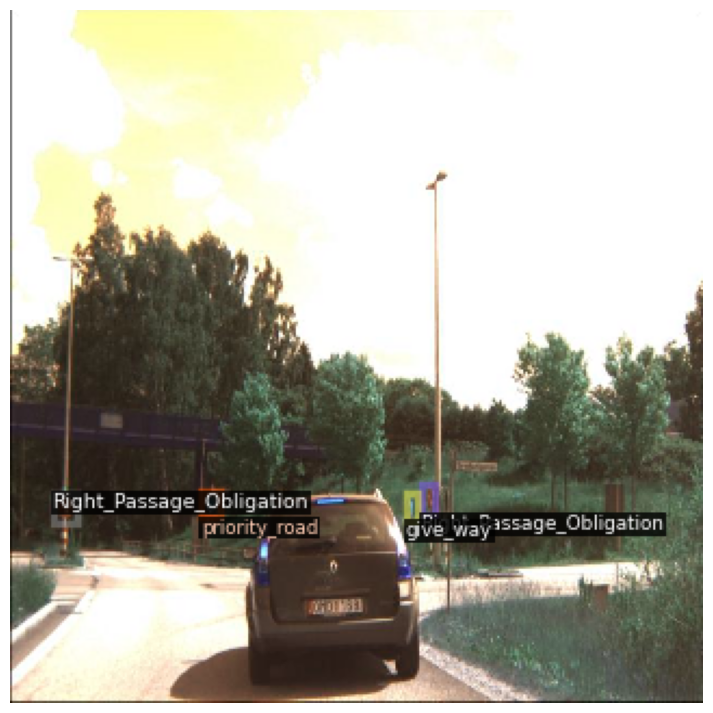

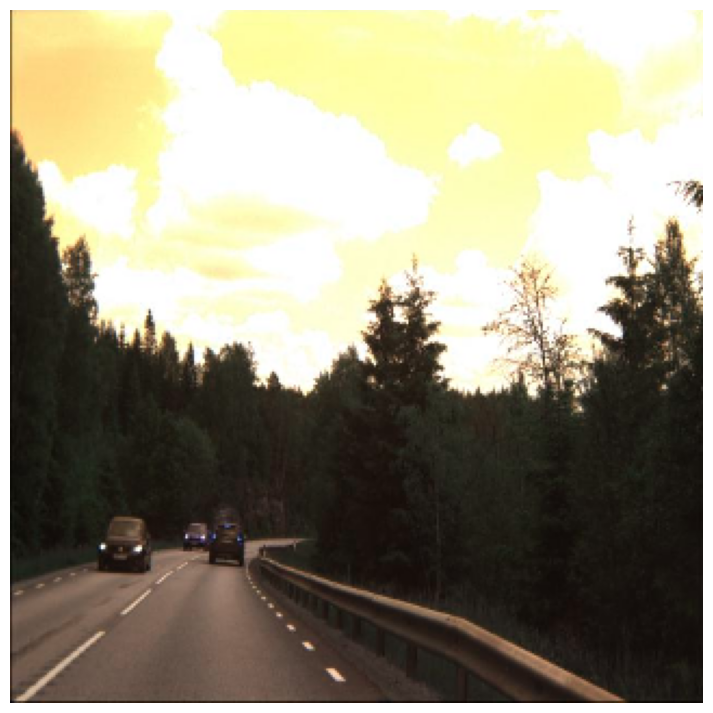

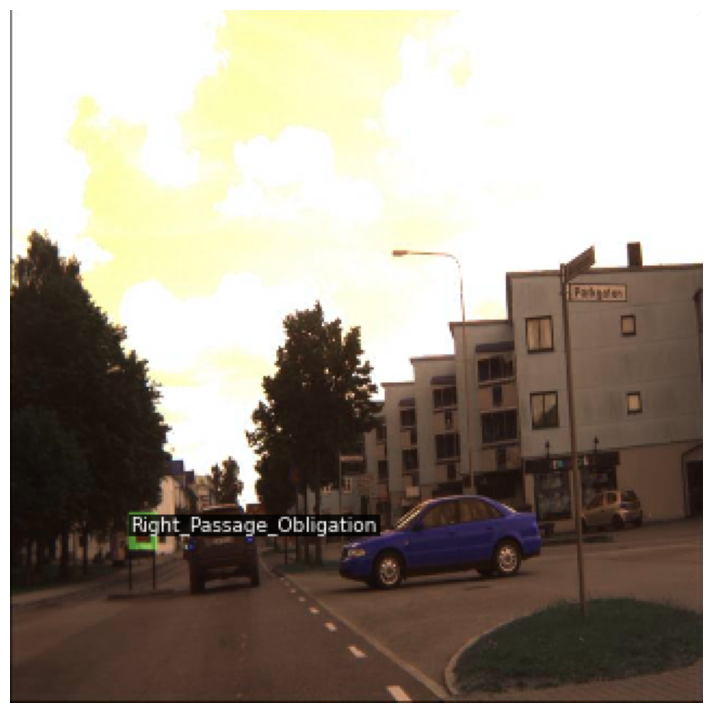

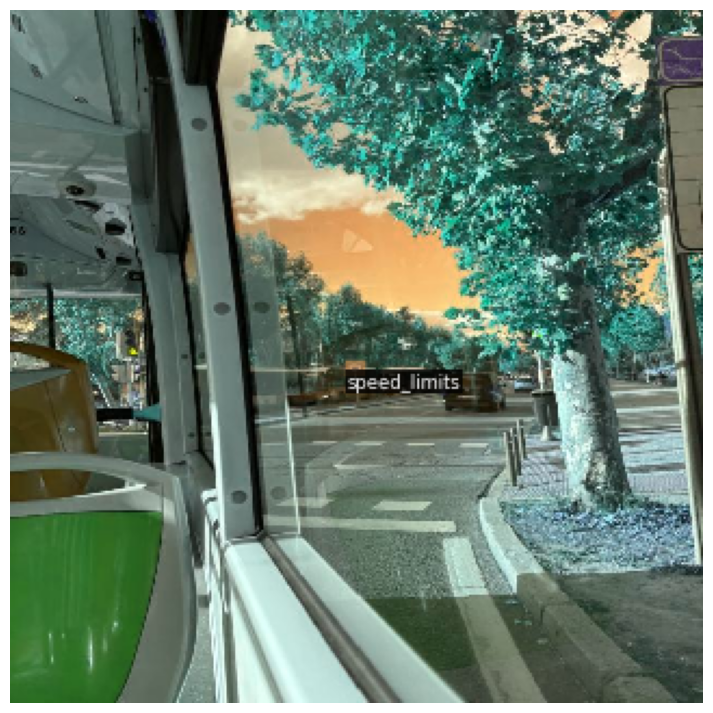

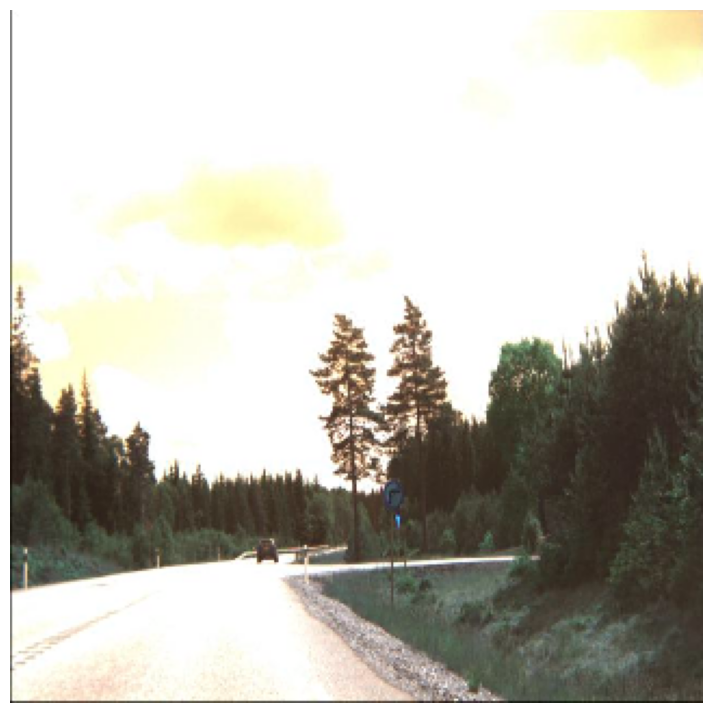

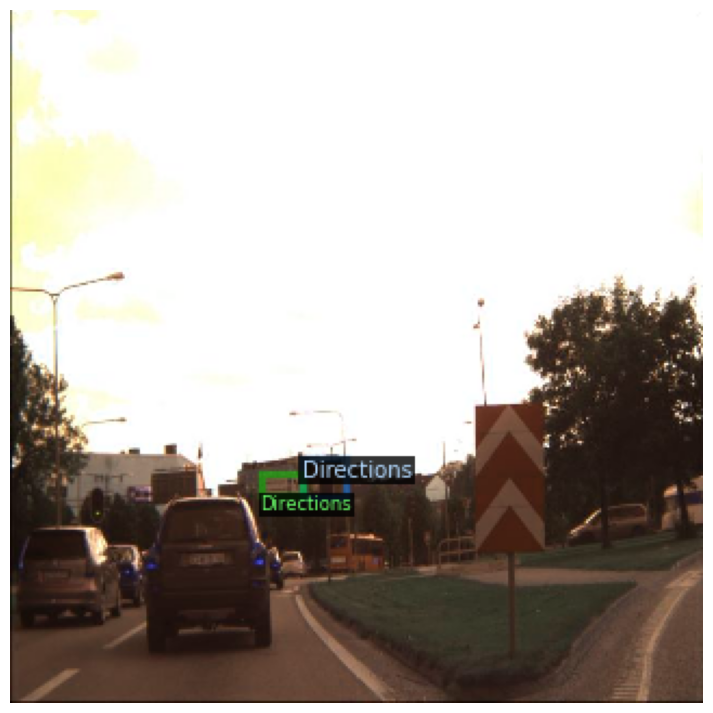

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    plt.figure(figsize=(12, 9))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()


## Struttura Dataset

In [9]:
my_dataset_train_metadata

namespace(name='my_dataset_train',
          json_file='/kaggle/working/Object-Detection-Signals-1/train/_annotations.coco.json',
          image_root='/kaggle/working/Object-Detection-Signals-1/train',
          evaluator_type='coco',
          thing_classes=['Signals',
                         'Directions',
                         'Do_not_stop',
                         'Right_Passage_Obligation',
                         'deviation',
                         'give_way',
                         'parking_area',
                         'pedestrian_crossing',
                         'priority_road',
                         'prohibition',
                         'speed_limits',
                         'stop',
                         'work_in_progress'],
          thing_dataset_id_to_contiguous_id={0: 0,
                                             1: 1,
                                             2: 2,
                                             3: 3,
                          

## Numero di occorrenze per ciascuna classe

In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("my_dataset_train")
metadata = MetadataCatalog.get("my_dataset_train")

class_counts = {class_name: 0 for class_name in metadata.thing_classes}

for d in dataset_dicts:
    for ann in d['annotations']:
        class_id = ann['category_id']
        class_name = metadata.thing_classes[class_id]
        class_counts[class_name] += 1

for class_name, count in class_counts.items():
    print(f"Classe '{class_name}': {count} elementi")


Classe 'Signals': 0 elementi
Classe 'Directions': 447 elementi
Classe 'Do_not_stop': 117 elementi
Classe 'Right_Passage_Obligation': 170 elementi
Classe 'deviation': 43 elementi
Classe 'give_way': 181 elementi
Classe 'parking_area': 57 elementi
Classe 'pedestrian_crossing': 321 elementi
Classe 'priority_road': 156 elementi
Classe 'prohibition': 40 elementi
Classe 'speed_limits': 272 elementi
Classe 'stop': 13 elementi
Classe 'work_in_progress': 20 elementi


---

# TRANING FASTER-RCNN

### Avvio dell'Addestramento del Modello Faster R-CNN

In questa sezione, viene configurato e avviato l'addestramento del modello di object detection **Faster R-CNN**.

**Configurazione Principale:**
* **Durata Addestramento**:
    * Epoche totali: **60 epoche**.
    * Iterazioni totali: **41700** (calcolate come 60 epoche * 695 iterazioni/epoca).
* **Batch Size**: 8 immagini per batch.
* **Learning Rate Iniziale**:  0.001.

**Checkpointing e Valutazione:**
* **Salvataggio Checkpoint**: Un checkpoint del modello verrà salvato ogni **20 epoche** (ogni 13900 iterazioni).
* **Valutazione Periodica**: Le prestazioni del modello sul set di validazione (`"my_dataset_val"`) verranno calcolate ogni **epoca** (ogni 695 iterazioni) utilizzando `COCOEvaluator`.

### funzione per calcolare e registrare periodicamente le diverse componenti della Loss

In [11]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
        
        start_time = time.perf_counter()
        total_compute_time = 0
        
        classification_losses = []
        regression_losses = []
        rpn_cls_losses = []
        rpn_bbox_losses = []
        total_losses = []
        
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            
            cls_loss_batch, reg_loss_batch, rpn_cls_loss_batch, rpn_bbox_loss_batch = self._get_loss(inputs)
            classification_losses.append(cls_loss_batch)
            regression_losses.append(reg_loss_batch)
            rpn_cls_losses.append(rpn_cls_loss_batch)
            rpn_bbox_losses.append(rpn_bbox_loss_batch)
            
            total_loss_batch = cls_loss_batch + reg_loss_batch + rpn_cls_loss_batch + rpn_bbox_loss_batch
            total_losses.append(total_loss_batch)

        mean_cls_loss = np.mean(classification_losses)
        mean_reg_loss = np.mean(regression_losses)
        mean_rpn_cls_loss = np.mean(rpn_cls_losses)
        mean_rpn_bbox_loss = np.mean(rpn_bbox_losses)
        mean_total_loss = np.mean(total_losses)

        # Salva le perdite per TensorBoard
        self.trainer.storage.put_scalar('validation_total_loss', mean_total_loss)
        self.trainer.storage.put_scalar('validation_classification_loss', mean_cls_loss)
        self.trainer.storage.put_scalar('validation_regression_loss', mean_reg_loss)
        self.trainer.storage.put_scalar('validation_rpn_cls_loss', mean_rpn_cls_loss)
        self.trainer.storage.put_scalar('validation_rpn_bbox_loss', mean_rpn_bbox_loss)

        comm.synchronize()

        return classification_losses, regression_losses, rpn_cls_losses, rpn_bbox_losses
            
    def _get_loss(self, data):
        
        metrics_dict = self._model(data)

        cls_loss = metrics_dict.get('loss_cls', 0)
        reg_loss = metrics_dict.get('loss_box_reg', 0)
        rpn_cls_loss = metrics_dict.get('loss_rpn_cls', 0)
        rpn_bbox_loss = metrics_dict.get('loss_rpn_bbox', 0)

        cls_loss = cls_loss.detach().cpu().item() if isinstance(cls_loss, torch.Tensor) else float(cls_loss)
        reg_loss = reg_loss.detach().cpu().item() if isinstance(reg_loss, torch.Tensor) else float(reg_loss)
        rpn_cls_loss = rpn_cls_loss.detach().cpu().item() if isinstance(rpn_cls_loss, torch.Tensor) else float(rpn_cls_loss)
        rpn_bbox_loss = rpn_bbox_loss.detach().cpu().item() if isinstance(rpn_bbox_loss, torch.Tensor) else float(rpn_bbox_loss)

        return cls_loss, reg_loss, rpn_cls_loss, rpn_bbox_loss
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()

        self.trainer.storage.put_scalars(timetest=12)


## funzione per la progress bar

In [12]:
class TQDMHook(hooks.HookBase):
    def __init__(self, max_iter, eval_period):
        self.pbar = tqdm(total=max_iter, desc="Training Progress")
        self.eval_period = eval_period

    def after_step(self):
        self.pbar.update(1)

        metrics = self.trainer.storage.latest()

        total_loss = metrics.get("total_loss", 0)
        lr = metrics.get("lr", 0)

        
        postfix = {
            'train_loss': total_loss,
            'lr': lr
        }

        
        self.pbar.set_postfix(postfix)

        next_iter = self.trainer.iter + 1
        if next_iter % self.eval_period == 0 or next_iter == self.trainer.max_iter:
            self._update_validation_losses()

    def _update_validation_losses(self):

        metrics = self.trainer.storage.latest()

        validation_total_loss = metrics.get("validation_total_loss", None)
        validation_cls_loss = metrics.get("validation_classification_loss", None)
        validation_reg_loss = metrics.get("validation_regression_loss", None)
        validation_rpn_cls_loss = metrics.get("validation_rpn_cls_loss", None)
        validation_rpn_bbox_loss = metrics.get("validation_rpn_bbox_loss", None)

        postfix = {}

        if validation_total_loss is not None:
            postfix['val_total_loss'] = validation_total_loss
        if validation_cls_loss is not None:
            postfix['val_cls_loss'] = validation_cls_loss
        if validation_reg_loss is not None:
            postfix['val_reg_loss'] = validation_reg_loss
        if validation_rpn_cls_loss is not None:
            postfix['val_rpn_cls_loss'] = validation_rpn_cls_loss
        if validation_rpn_bbox_loss is not None:
            postfix['val_rpn_bbox_loss'] = validation_rpn_bbox_loss

        if postfix:
            self.pbar.set_postfix(postfix)

    def after_train(self):
        self.pbar.close()


### Definizione del Trainer Personalizzato 

In [ ]:

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            
            os.makedirs(cfg.OUTPUT_DIR + "/inference", exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

## Configurazioni del modello

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)


cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 16  
cfg.SOLVER.MAX_ITER =  4173   #60 epoche
cfg.SOLVER.CHECKPOINT_PERIOD = 1391 #salva ogni 20 epoche

cfg.SOLVER.BASE_LR = 0.001  # Learning rate iniziale
cfg.SOLVER.WARMUP_ITERS = 695  # Numero di iterazioni di warmup
cfg.TEST.EVAL_PERIOD = 695 #ogni epoca valutazione


cfg.SOLVER.GAMMA = 0.1  

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.OUTPUT_DIR = workdir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Frequenza di valutazione


---

## avvio training

In [15]:
#nuovo
trainer = MyTrainer(cfg)
trainer.register_hooks([TQDMHook(cfg.SOLVER.MAX_ITER,cfg.TEST.EVAL_PERIOD)])
trainer.resume_or_load(resume=False)
trainer.train()

Training Progress:   0%|          | 0/4173 [00:00<?, ?it/s]
model_final_280758.pkl: 0.00B [00:00, ?B/s]
model_final_280758.pkl:   0%|          | 442k/167M [00:00<00:38, 4.32MB/s]
model_final_280758.pkl:   2%|▏         | 2.76M/167M [00:00<00:10, 15.3MB/s]
model_final_280758.pkl:   4%|▍         | 6.55M/167M [00:00<00:06, 25.6MB/s]
model_final_280758.pkl:   8%|▊         | 12.9M/167M [00:00<00:03, 40.4MB/s]
model_final_280758.pkl:  15%|█▍        | 24.7M/167M [00:00<00:02, 68.1MB/s]
model_final_280758.pkl:  27%|██▋       | 45.1M/167M [00:00<00:01, 114MB/s] 
model_final_280758.pkl:  43%|████▎     | 72.6M/167M [00:00<00:00, 167MB/s]
model_final_280758.pkl:  66%|██████▌   | 111M/167M [00:00<00:00, 235MB/s] 
model_final_280758.pkl: 167MB [00:00, 168MB/s]                           
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
Training Progress:   0%|          | 19/4173 [00:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.

Training Progress:  33%|███▎      | 1389/4173 [32:28<1:03:40,  1.37s/it, train_loss=(0.3799344068393111, 1388), lr=(0.001, 1388)]                                                                                                                                               

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.869
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.

Training Progress:  50%|████▉     | 2084/4173 [48:52<47:26,  1.36s/it, train_loss=(0.3040789959486574, 2083), lr=(0.001, 2083)]                                                                                                                                                       

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.

Training Progress:  67%|██████▋   | 2779/4173 [1:05:17<32:34,  1.40s/it, train_loss=(0.3167917544487864, 2778), lr=(0.001, 2778)]                                                                                                                                                   

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.

Training Progress:  83%|████████▎ | 3474/4173 [1:21:42<15:34,  1.34s/it, train_loss=(0.33217548206448555, 3473), lr=(0.001, 3473)]                                                                                                                                                      

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.

Training Progress: 100%|█████████▉| 4169/4173 [1:38:02<00:05,  1.36s/it, train_loss=(0.26570011605508626, 4168), lr=(0.001, 4168)]                                                                                                                                                    

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.664
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.

Training Progress: 100%|██████████| 4173/4173 [1:38:56<00:00,  9.61s/it, val_total_loss=(0.35884005822798004, 4172), val_cls_loss=(0.09241001610885684, 4172), val_reg_loss=(0.25011611914953347, 4172), val_rpn_cls_loss=(0.016313922969589726, 4172), val_rpn_bbox_loss=(0.0, 4172)]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.558
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.

Training Progress: 100%|██████████| 4173/4173 [1:39:14<00:00,  1.43s/it, val_total_loss=(0.35884005822798004, 4172), val_cls_loss=(0.09241001610885684, 4172), val_reg_loss=(0.25011611914953347, 4172), val_rpn_cls_loss=(0.016313922969589726, 4172), val_rpn_bbox_loss=(0.0, 4172)]


---

# Valutazione del Modello Faster R-CNN a Diverse Epoche di Addestramento

In questa fase, valuto le prestazioni del modello **Faster R-CNN** utilizzando i checkpoint salvati a differenti stadi dell'addestramento. L'obiettivo è osservare come le metriche di performance evolvono al crescere del numero di epoche.

Verranno eseguiti i seguenti passaggi per ciascun checkpoint selezionato:

1.  **Caricamento della Configurazione e dei Pesi Specifici:**
    * La configurazione base del modello verrà caricata.
    * Verranno impostati i parametri per la fase di test.
    * Di volta in volta, il parametro `cfg.MODEL.WEIGHTS` verrà aggiornato per puntare ai file dei pesi corrispondenti a:
        * **20 epoche** di addestramento
        * **40 epoche** di addestramento
        * **60 epoche** di addestramento 

2.  **Preparazione per l'Inferenza sul Set di Test:**
    * Verrà istanziato un `COCOEvaluator` per il dataset di test.
    * Verrà creato un `DataLoader` per il set di test.

3.  **Esecuzione dell'Inferenza e Raccolta Metriche:**
    * Per ogni set di pesi, il modello eseguirà l'inferenza sull'intero dataset di test.
    * L'`evaluator` calcolerà e registrerà le metriche di prestazione.

# Inferenza utilizzando il set di pesi dopo 20 epoche

In [15]:

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


In [16]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = workdir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/kaggle/working/faster-cnn1/model_0001390.pth")
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST  = 0.7  # Soglia NMS per i risultati finali
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3 
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./fastrCnn/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")

inference_on_dataset(trainer.model, val_loader, evaluator)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.816
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox',
              {'AP': 48.95347069884666,
               'AP50': 81.64842398133771,
               'AP75': 55.30462274981427,
               'APs': 47.40542624788333,
               'APm': 62.03537936889456,
               'APl': 67.56841755604131,
               'AP-Signals': nan,
               'AP-Directions': 54.22703217188064,
               'AP-Do_not_stop': 53.37513971177338,
               'AP-Right_Passage_Obligation': 51.63060998396214,
               'AP-deviation': 65.04950495049505,
               'AP-give_way': 42.191319108869415,
               'AP-parking_area': 23.756276943483826,
               'AP-pedestrian_crossing': 40.82957236033577,
               'AP-priority_road': 47.70000128244886,
               'AP-prohibition': 50.02357378595001,
               'AP-speed_limits': 50.4903012552776,
               'AP-stop': 45.0,
               'AP-work_in_progress': 63.16831683168317})])

# Inferenza utilizzando il set di pesi dopo 40 epoche

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = workdir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/kaggle/working/faster-cnn1/model_0002781.pth")
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST  = 0.7  # Soglia NMS per i risultati finali
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./fasterCnn2/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")

inference_on_dataset(trainer.model, val_loader, evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.836
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.584
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox',
              {'AP': 50.11016657744493,
               'AP50': 83.55610427307603,
               'AP75': 56.07030219751591,
               'APs': 48.36249265677818,
               'APm': 64.99494713138698,
               'APl': 77.2779893373953,
               'AP-Signals': nan,
               'AP-Directions': 53.47356371261349,
               'AP-Do_not_stop': 52.45934593459346,
               'AP-Right_Passage_Obligation': 54.05725385068839,
               'AP-deviation': 75.14851485148515,
               'AP-give_way': 40.767139613847846,
               'AP-parking_area': 28.042555217060166,
               'AP-pedestrian_crossing': 45.32292842159089,
               'AP-priority_road': 45.396059730196626,
               'AP-prohibition': 49.05940594059406,
               'AP-speed_limits': 56.40711284478792,
               'AP-stop': 40.0,
               'AP-work_in_progress': 61.18811881188119})])

# Inferenza utilizzando il set pesi dopo 60 epoche

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = workdir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/kaggle/working/faster-cnn1/model_0004172.pth")
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST  = 0.7  # Soglia NMS per i risultati finali
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./fasterCnn3/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")

inference_on_dataset(trainer.model, val_loader, evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.874
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.630
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox',
              {'AP': 52.993946555535075,
               'AP50': 87.36783222288655,
               'AP75': 57.71828567593281,
               'APs': 47.86663041626078,
               'APm': 64.87608588240728,
               'APl': 80.55179408918335,
               'AP-Signals': nan,
               'AP-Directions': 55.73222991758566,
               'AP-Do_not_stop': 50.23292713886774,
               'AP-Right_Passage_Obligation': 48.42921731427386,
               'AP-deviation': 75.14851485148515,
               'AP-give_way': 42.44208864269131,
               'AP-parking_area': 30.126940303920502,
               'AP-pedestrian_crossing': 44.65112226103057,
               'AP-priority_road': 41.69889875218937,
               'AP-prohibition': 40.424328147100425,
               'AP-speed_limits': 55.951982426385364,
               'AP-stop': 90.0,
               'AP-work_in_progress': 61.089108910891085})])


# visualizzazione predizioni 

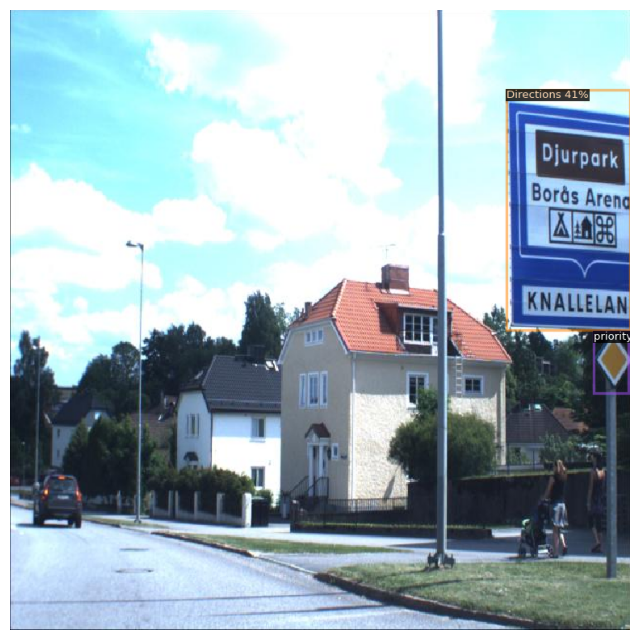

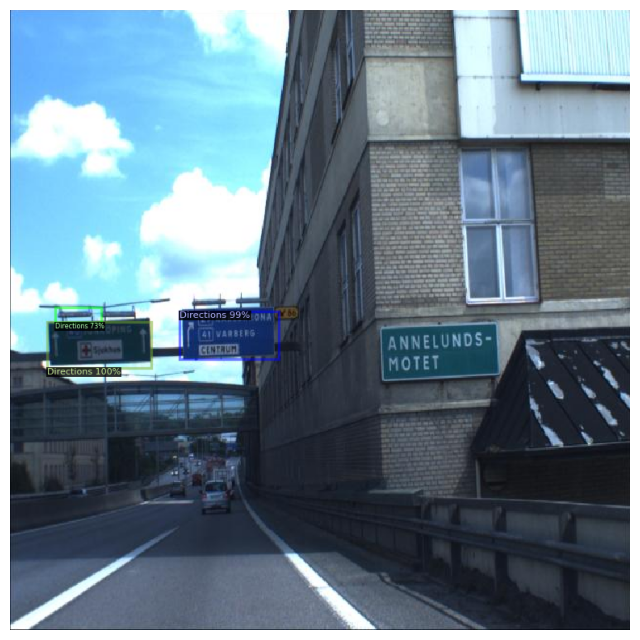

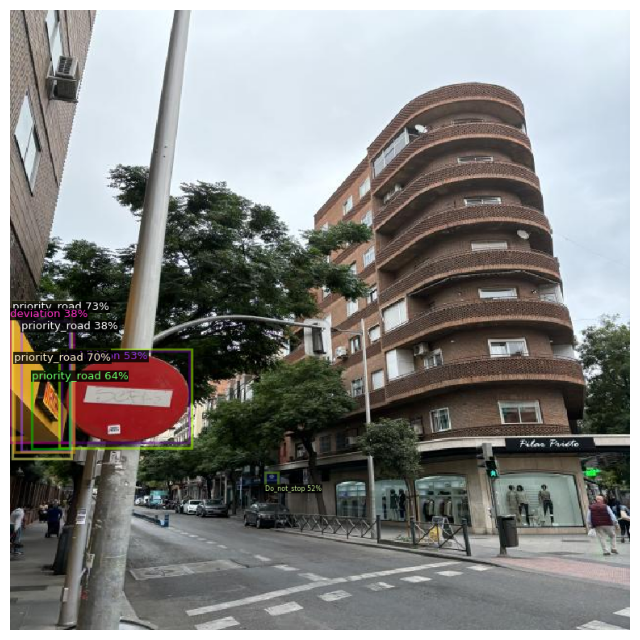

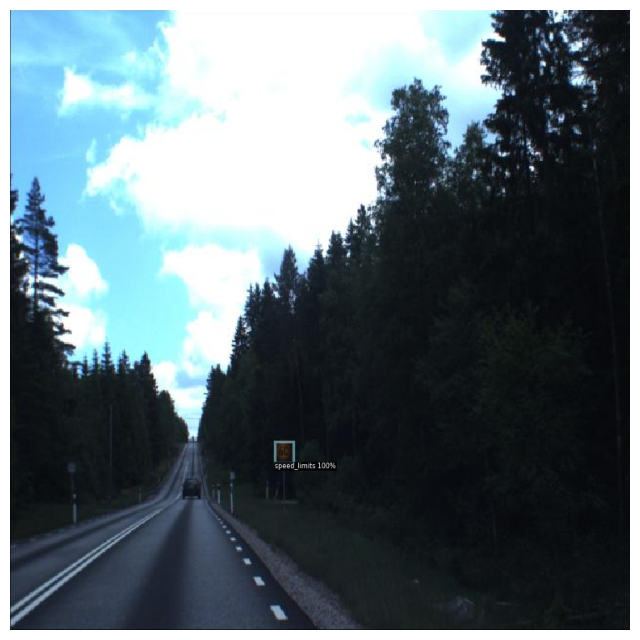

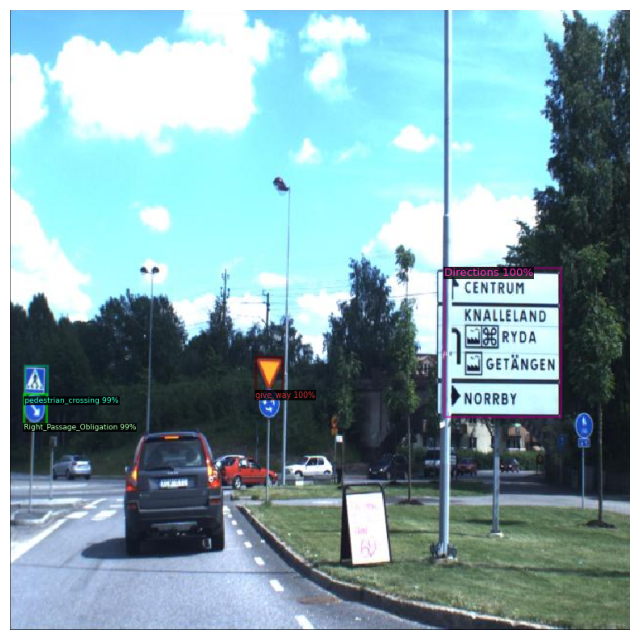

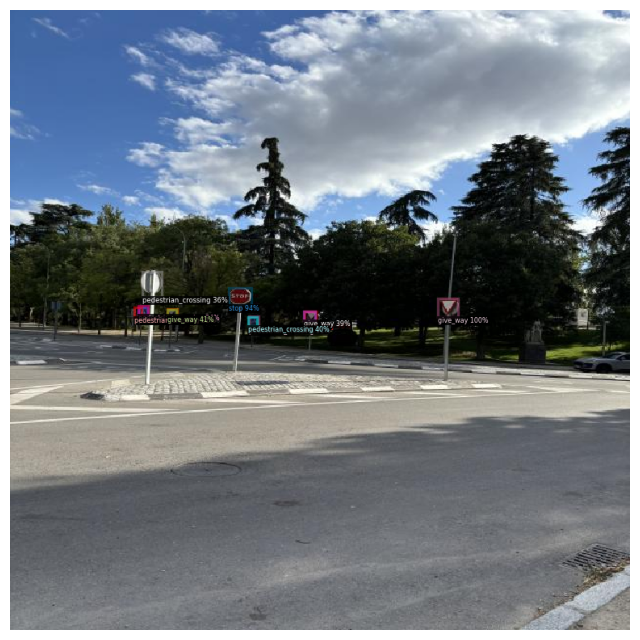

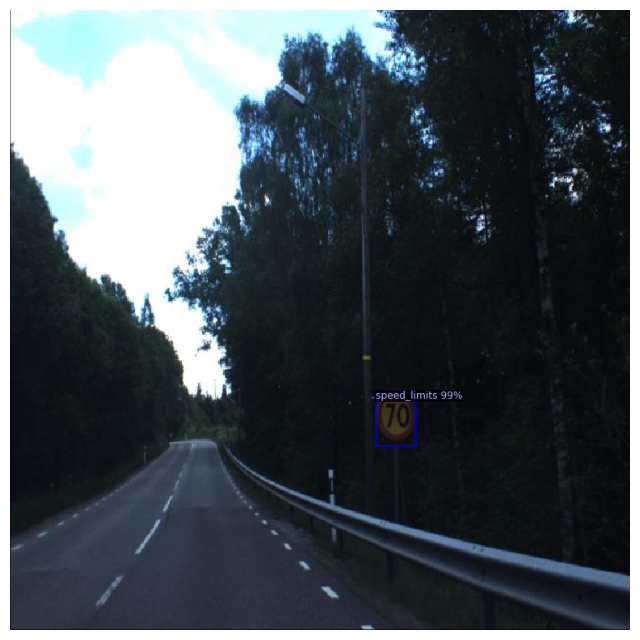

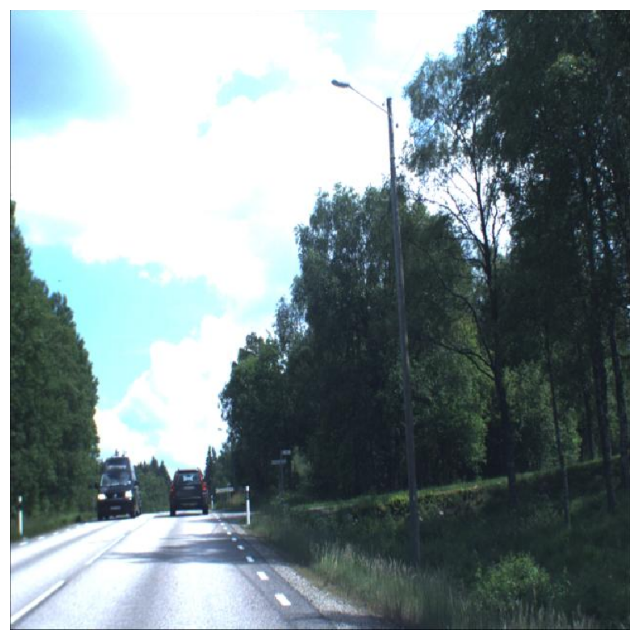

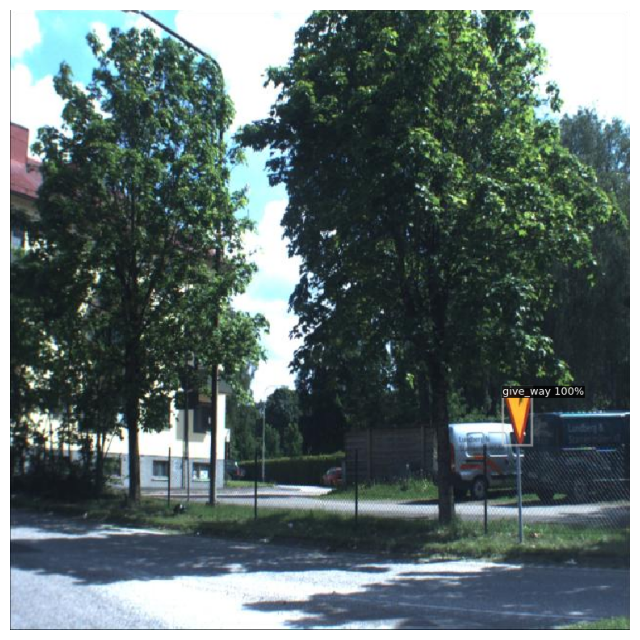

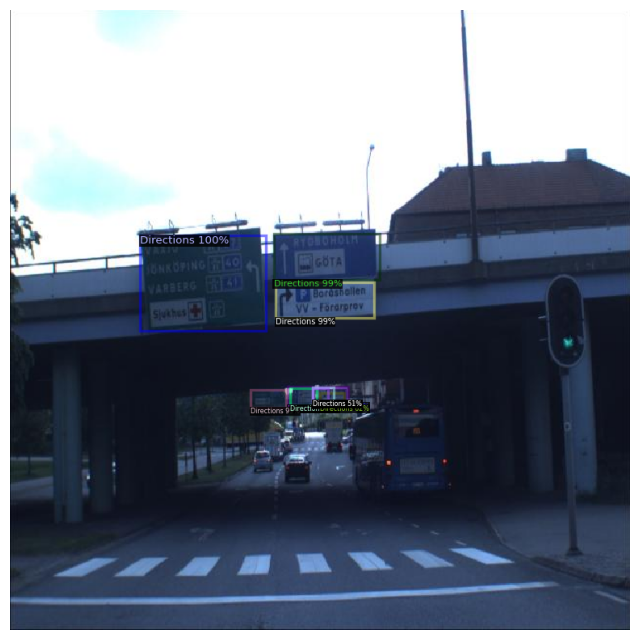

In [19]:
import torch
import cv2
import glob
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

model = trainer.model
model.eval()  

co = 0

for img in glob.glob(nome_del_dataset + '/test/*.jpg')[:10]:
    if co==15:
        break

    inputs = cv2.imread(img)
    
    inputs_tensor = torch.as_tensor(inputs.astype("float32").transpose(2, 0, 1))  
    inputs_tensor = [{"image": inputs_tensor}]

    # Eseguo l'inferenza
    with torch.no_grad():  
        outputs = model(inputs_tensor)

    co += 1 
    
    metadata_test = MetadataCatalog.get("my_dataset_test")
    
    # Visualizza i risultati
    v = Visualizer(inputs[:, :, ::-1], metadata=metadata_test, scale=1.2)
    out = v.draw_instance_predictions(outputs[0]['instances'].to('cpu'))
    # Visualizza l'immagine usando matplotlib
    plt.figure(figsize=(8,12))
    plt.imshow(out.get_image()[:, :, ::]) 
    plt.axis('off')
    plt.show()


# Download

In [3]:
import shutil
from IPython.display import HTML

def zip_folder(folder_path, output_path):
    shutil.make_archive(output_path, 'zip', folder_path)

def create_download_link(zip_file_name):
    return HTML('<a href="{}" target="_blank" download>Click here to download {}</a>'.format(zip_file_name, zip_file_name))

folder_to_zip = workdir 
zip_file_name = workdir 

zip_folder(folder_to_zip, zip_file_name)

create_download_link(zip_file_name + '.zip')
